In [30]:
import os, sys
sys.path.insert(0, '/home/jtorrenc/mvesc/ETL')
sys.path.insert(0, '/home/jtorrenc/mvesc/Models_Results')
from mvesc_utility_functions import *
from save_reports import *
from my_timer import Timer
import numpy as np
import pandas as pd
import random
from functools import partial
import itertools
import pickle
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def color_gt(val,x=.5,c='blue',neg=True):
    """
    Colors values greater than x blue (or other provided color)
    
    :param float x: lower bound on colored values
    :param str c: color
    :param bool neg: if true, color negative values red
    :returns: css string to color values in dataframe
    :rtype: str
    """
    
    if val > x:
        color = c 
    elif val < 0:
        color = 'red' 
    else: color = 'black'
    return 'color: %s' % color

def table_exists(cursor, table, schema='clean'):
    """
    Checks to see if a table exists in the database
    
    :param pg.cursor cursor: 
    :param str table:
    :param str schema:
    :rtype: bool
    """
    cursor.execute("""                                                   
            select count(*) from information_schema.tables                       
            where table_schema = %s and table_name = %s
            """, [schema, table])
    return cursor.fetchall()[0][0]

In [5]:
def plot_metric(y_scores, y_true, ax, gr, max_k, metric='recall'):
    if type(y_scores) != pd.core.series.Series:
        try:
            y_scores = pd.Series(y_scores)
        except:
            print('y_scores must be a Series or a DataFrame')
            sys.exit(1)
            
    n = int(len(y_scores)*(max_k))
    curve = np.zeros([n,1])
    ranks = y_scores.rank(method='first', ascending=False)
    if metric=='recall':
        scorer = recall_score
    elif metric=='precision':
        scorer = precision_score
    else:
        print('metric not found')
    for i in range(n):
        pred = pd.Series([1 if r <= i+1 else 0 for r in ranks])
        curve[i] = scorer(y_true, pred)
    
    percents = (np.arange(n)+1)/len(y_scores)
    ax.plot(percents, curve, label = str(gr))

In [9]:
with postgres_pgconnection_generator() as connection:
    with connection.cursor() as cursor:
        cursor.execute('select distinct model_name from model.reports')
        model_list = ['DT','ET','logit','RF','SVM']
        best = dict()
        features = dict()
        spearman = dict()
        for gr in range(6,11):
            temp = pd.DataFrame()
            best[gr] = dict()
            for m in model_list:
                cursor.execute("""select filename from model.reports 
                            where model_name = '{}'
                            and batch_name like '08_12%'
                            and prediction_grade = {}
                            and label = 'definite_plus_ogt'
                            order by val_precision_5_15 desc limit 1; """.format(m,gr))
                filename = cursor.fetchall()
                best[gr][m] = filename[0][0]
        file_list = list(itertools.chain(*[list(b.values()) for b in best.values()]))
        file_list = "('" + '\', \''.join(file_list) + "')"
        print(file_list)
        cursor.execute("select * from model.reports where filename in " + file_list 
                      + " and cv_criterion = 'custom_precision_5_15';")
        results_raw = cursor.fetchall()
        cursor.execute("select * from model.reports limit 0")
        cols = [desc[0] for desc in cursor.description]
        results = pd.DataFrame(results_raw, columns=cols)

('08_12_2016_grade_8_param_set_29_logit_ht_22749', '08_12_2016_grade_8_param_set_35_RF_ht_23861', '08_12_2016_grade_8_param_set_23_ET_ht_21640', '08_12_2016_grade_8_param_set_17_SVM_ht_20333', '08_12_2016_grade_8_param_set_22_DT_ht_21308', '08_12_2016_grade_9_param_set_16_logit_ht_21138', '08_12_2016_grade_9_param_set_5_RF_ht_17719', '08_12_2016_grade_9_param_set_23_ET_ht_23119', '08_12_2016_grade_9_param_set_16_SVM_ht_21445', '08_12_2016_grade_9_param_set_35_DT_ht_25202', '08_12_2016_grade_10_param_set_22_logit_ht_23461', '08_12_2016_grade_10_param_set_22_RF_ht_23591', '08_12_2016_grade_10_param_set_22_ET_ht_23661', '08_12_2016_grade_10_param_set_22_SVM_ht_23672', '08_12_2016_grade_10_param_set_11_DT_ht_20430', '08_12_2016_grade_6_param_set_11_logit_ht_17102', '08_12_2016_grade_6_param_set_8_RF_ht_16687', '08_12_2016_grade_6_param_set_8_ET_ht_16726', '08_12_2016_grade_6_param_set_11_SVM_ht_17277', '08_12_2016_grade_6_param_set_8_DT_ht_16604', '08_12_2016_grade_7_param_set_11_logit_ht_

In [10]:
results[results['prediction_grade']==6]\
    [['model_name','val_recall_5_15','prediction_grade','feature_grades','label','parameters',
        'feature_1','feature_1_weight','feature_2','feature_2_weight','feature_3','feature_3_weight']]\
    .sort_values('val_recall_5_15',ascending=False)

,model_name,val_recall_5_15,prediction_grade,feature_grades,label,parameters,feature_1,feature_1_weight,feature_2,feature_2_weight,feature_3,feature_3_weight
2,ET,0.378972,6,5,definite_plus_ogt,criterion = gini; max_depth = 50; max_features...,socstudies_normalized_gr_5,0.052510,read_normalized_gr_5,0.050524,science_normalized_gr_5,0.048914
5,logit,0.372430,6,5,definite_plus_ogt,C = 10.0; penalty = l1,status_gr_5_foster,2.992704,status_gr_5_deleted,2.880639,special_ed_gr_5_50,2.769943
1,RF,0.370093,6,5,definite_plus_ogt,criterion = gini; max_depth = 50; max_features...,science_normalized_gr_5,0.080431,socstudies_normalized_gr_5,0.073461,read_normalized_gr_5,0.073134
6,SVM,0.342523,6,5,definite_plus_ogt,C = 0.01; kernel = linear,iss_gr_5,0.030000,ethnicity_M,0.023483,disability_gr_5_emotional disturbance,0.020000
0,DT,0.336916,6,5,definite_plus_ogt,criterion = gini; max_depth = 5; max_features ...,socstudies_normalized_gr_5,0.430202,math_normalized_gr_4,0.174315,gpa_district_gr_5,0.115174


In [ ]:
scores_list = dict()
scores = dict()
y_list = dict()
y = dict()
with Timer('reading_in_predictions') as t:
    for model in ['logit', 'RF']:
        df_list = []
        grade_range = range(6,11)
        with postgres_pgconnection_generator() as connection:
            with connection.cursor() as cursor:
                for gr in grade_range:
                    print('grade '+str(gr))
                    cursor.execute("""select student_lookup,true_label,predicted_score,split from model.predictions
                                    where filename = '{0}'; """.format(best[gr][model]))
                    temp = cursor.fetchall()
                    temp = pd.DataFrame(temp, columns = ['student_lookup','true_label','predicted_score','split'])
                    print(gr, temp.shape)
                    temp = temp[temp['split']!='train']
                    print(gr, temp.shape)
                    temp.set_index('student_lookup', inplace=True)
                    df_list.append(temp)
                    run_time = t.time_check()
                    print('model {0}, grade {1}, time {2}'.format(model, gr, run_time))

        scores_list[model] = [pd.DataFrame(d['predicted_score']) for d in df_list]
        y_list[model] = [pd.DataFrame(d['true_label']) for d in df_list]

        for i, gr in enumerate(grade_range):
            scores_list[model][i].rename(columns = {'predicted_score': 'predicted_score_{0}'.format(gr)}, inplace=True)
        for i, gr in enumerate(grade_range):
            y_list[model][i].rename(columns = {'true_label': 'true_label_{0}'.format(gr)}, inplace=True)

        scores[model] = scores_list[model][0]
        for df in scores_list[model][1:]:
            scores[model] = scores[model].join(df, how='inner')
        y[model] = y_list[model][0]
        for df in y_list[model][1:]:
            y[model] = y[model].join(df, how='inner')

grade 6


In [ ]:
plot_precision_recall_n(y['logit']['true_label_{}'.format(10)], scores['logit']['predicted_score_{}'.format(10)], 
                        '.', 'grade_10', 'logit')

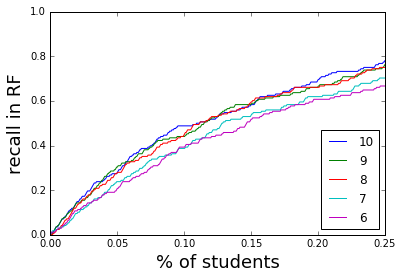

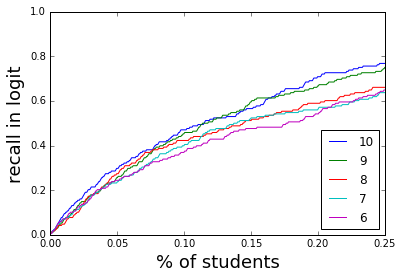

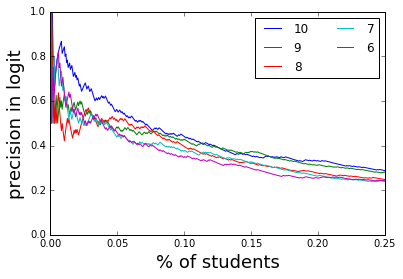

In [15]:
max_k = .25
for model in ['RF', 'logit']:
    plt.clf()
    fig1, ax1 = plt.subplots()
    fig2, ax2 = plt.subplots()

    for gr in np.arange(10,5,-1):
        plot_metric(scores[model]['predicted_score_{}'.format(gr)], y[model]['true_label_{}'.format(gr)], ax1, gr, max_k, 'recall')
        plot_metric(scores[model]['predicted_score_{}'.format(gr)], y[model]['true_label_{}'.format(gr)], ax2, gr, max_k, 'precision')

    plt.figure(fig1.number)
    ax1.legend(loc="lower right")
    ax1.set_xlabel("% of students", fontsize=18)
    ax1.set_ylabel('recall in {}'.format(model), fontsize=18)
    ax1.set_ylim([0,1])
    ax1.set_xlim([0,max_k])
    plt.savefig('recall_comparison_{}.png'.format(model))

    plt.figure(fig2.number)
    ax2.legend(loc="upper right", ncol=2)
    ax2.set_xlabel("% of students", fontsize=18)
    ax2.set_ylabel('precision in {}'.format(model), fontsize=18)
    ax2.set_ylim([0,1])
    ax2.set_xlim([0,max_k])
    plt.savefig('precision_comparison_{}.png'.format(model))

 ...]

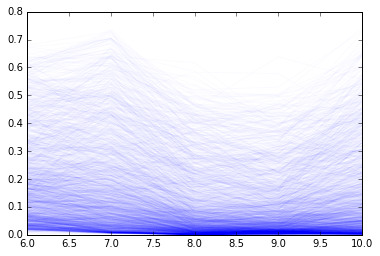

In [20]:
plt.clf()
fig1, ax1 = plt.subplots()
ax1.plot(range(6,11), scores['RF'].as_matrix().transpose(), alpha=0.015, color = 'b')

#[scores.rank().std(axis=1).le(250) & scores.rank().std(axis=1).ge(200)]


In [39]:
scores.rank().head()

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
12524.0,1739.0,1704.0,1841.0,1861.0,1888.0
269.0,333.0,237.0,29.0,201.0,34.0
286.0,1181.0,62.0,443.0,526.0,256.0
596.0,794.0,436.0,1100.0,547.0,634.0
624.0,1905.0,1605.0,1896.0,1784.0,1738.0


In [34]:
for gr in best.keys():
    print(best[gr]['RF'])

08_12_2016_grade_8_param_set_7_RF_ht_17694
08_12_2016_grade_9_param_set_0_RF_ht_15435
08_12_2016_grade_10_param_set_24_RF_ht_24033
08_12_2016_grade_6_param_set_0_RF_ht_15264
08_12_2016_grade_7_param_set_30_RF_ht_21620


In [47]:
scores.rank()[scores.index.isin(scores.rank().std(axis=1).sort_values(ascending=False).head(10).index)]
# 1910 have very little info, may be an artifact of imputed values?

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
4630.0,1798.0,88.0,1830.0,1860.0,1733.0
11491.0,7.0,1927.0,84.0,74.0,63.0
12565.0,451.0,94.0,123.0,1936.0,1146.0
14389.0,1932.0,20.0,1921.0,1777.0,1861.0
49273.0,1816.0,15.0,1623.0,1722.0,1736.0
50456.0,1660.0,45.0,1815.0,1889.0,1713.0
38223.0,1895.0,56.0,1804.0,1632.0,1590.0
49014.0,943.0,30.0,1867.0,1907.0,1674.0
50477.0,1747.0,1834.0,1913.0,18.0,1350.0


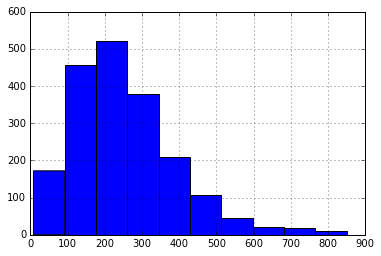

In [50]:
scores.rank().std(axis=1).hist()

In [49]:
scores.diff(axis=1)

,predicted_score_6,predicted_score_7,predicted_score_8,predicted_score_9,predicted_score_10
student_lookup,,,,,
12524.0,NaN,0.059486,-0.037131,0.170201,0.072546
269.0,NaN,-0.018626,-0.049356,-0.000558,-0.007235
286.0,NaN,-0.214373,0.014761,-0.014129,-0.016857
596.0,NaN,-0.057738,0.027781,-0.095637,-0.003134
624.0,NaN,-0.294285,0.158454,-0.143164,-0.148702
781.0,NaN,0.002267,-0.044566,-0.025610,-0.018065
785.0,NaN,-0.123985,-0.012612,0.034138,-0.049606
798.0,NaN,0.015346,0.007874,0.457854,-0.447179
809.0,NaN,-0.036837,-0.014328,-0.021069,0.001359


In [26]:
54216 in scores['RF']['predicted_score_10'].sort_values()

False